# Q5

This assignment covers Canny edge detector.

git clone https://github.com/scikit-image/scikit-image.git </br>
cd scikit-image </br>
pip install -e

In [46]:
from __future__ import print_function

# Setup
import numpy as np
import matplotlib.pyplot as plt
from time import time
# from skimage import io
import cv2 as cv2
import functools
import math
from collections import deque

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Part 1: Canny Edge Detector
In this part, you are going to implment Canny edge detector. The Canny edge detection algorithm can be broken down in to five steps:
1. Smoothing
2. Finding gradients
3. Non-maximum suppression
4. Double thresholding
5. Edge tracking by hysterisis

### 1.1 Smoothing
#### Implementation
We first smooth the input image by convolving it with a Gaussian kernel. The equation for a Gaussian kernel of size $(2k+1)\times(2k+1)$ is given by:

$$h_{ij}=\frac{1}{2\pi\sigma^2}\exp{\Bigl(-\frac{(i-k)^2+(j-k)^2}{2\sigma^2}\Bigr)}, 0\leq i,j < 2k+1$$

Implement **`conv`** and **`gaussian_kernel`**  and run the code below.

In [35]:
def conv(image, kernel):
    """ An implementation of convolution filter.

    This function uses element-wise multiplication and np.sum()
    to efficiently compute weighted sum of neighborhood at each
    pixel.

    Args:
        image: numpy array of shape (Hi, Wi)
        kernel: numpy array of shape (Hk, Wk)

    Returns:
        out: numpy array of shape (Hi, Wi)
    """
    Hi, Wi = image.shape
    Hk, Wk = kernel.shape
    out = np.zeros((Hi, Wi))

    # For this assignment, we will use edge values to pad the images.
    # Zero padding will make derivatives at the image boundary very big,
    # whereas we want to ignore the edges at the boundary.
    pad_width0 = Hk // 2
    pad_width1 = Wk // 2
    pad_width = ((pad_width0, pad_width0), (pad_width1, pad_width1))
    padded = np.pad(image, pad_width, mode='edge')

    # Iterate over each pixel position in the input image
    for i in range(Hi):
        for j in range(Wi):
            # Extract the neighborhood around the current pixel
            neighborhood = padded[i:i+Hk, j:j+Wk]
            # Perform element-wise multiplication between the neighborhood and the kernel
            weighted_sum = np.sum(neighborhood * kernel)
            # Assign the computed sum to the corresponding pixel position in the output array
            out[i, j] = weighted_sum

    return out


In [36]:
def gaussian_kernel(size, sigma):
    """ Implementation of Gaussian Kernel.

    This function follows the gaussian filter_values formula,
    and creates a filter_values matrix.

    Hints:
    - Use np.pi and np.exp to compute pi and exp

    Args:
        size: int of the size of output matrix
        sigma: float of sigma to calculate filter_values

    Returns:
        filter_values: numpy array of shape (size, size)
    """
    filter_values = np.zeros((size, size))

    # Compute the center of the kernel
    center = size // 2

    # Iterate over each pixel in the kernel
    for i in range(size):
        for j in range(size):
            # Compute the distance of the current pixel from the center
            distance = np.sqrt((i - center) ** 2 + (j - center) ** 2)
            # Compute the Gaussian function value for the current pixel
            filter_values[i, j] = np.exp(-distance ** 2 / (2 * sigma ** 2)) / (2 * np.pi * sigma ** 2)

    return filter_values

In [37]:
# Define 3x3 Gaussian kernel with std = 1
kernel = gaussian_kernel(3, 1)
kernel_test = np.array(
    [[ 0.05854983, 0.09653235, 0.05854983],
     [ 0.09653235, 0.15915494, 0.09653235],
     [ 0.05854983, 0.09653235, 0.05854983]]
)

# Test Gaussian kernel
if not np.allclose(kernel, kernel_test):
    print('Incorrect values! Please check your implementation.')

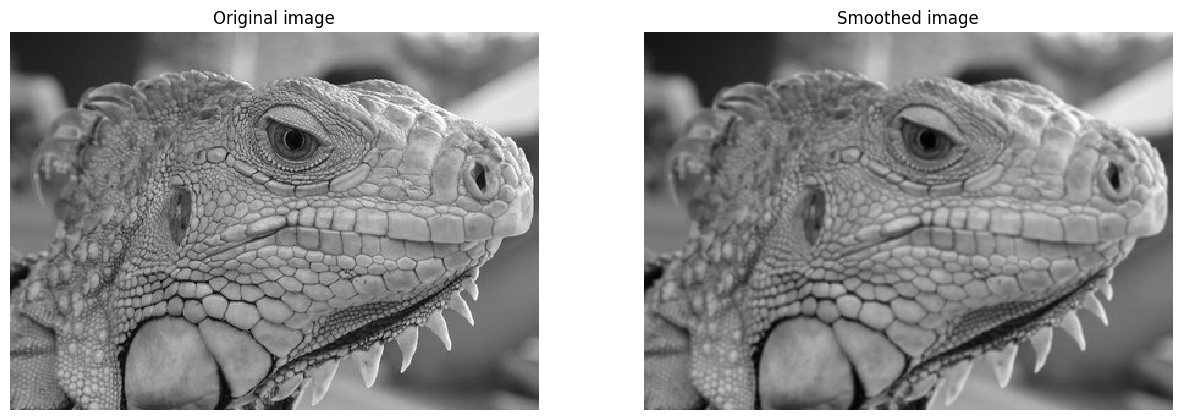

In [38]:
# Test with different kernel_size and sigma
kernel_size = 3
sigma = 1.2

# Load image
# img = io.imread('iguana.png', as_gray=True)
my_img = cv2.imread('iguana.png')
img = cv2.cvtColor(my_img, cv2.COLOR_BGR2GRAY)

# Define 5x5 Gaussian kernel with std = sigma
kernel = gaussian_kernel(kernel_size, sigma)
# Convolve image with kernel to achieve smoothed effect
smoothed = conv(img, kernel)

plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(smoothed)
plt.title('Smoothed image')
plt.axis('off')

plt.show()



### 1.2 Finding gradients

1.   List item
2.   List item


The gradient of a 2D scalar function $I:\mathbb{R}^2\rightarrow{\mathbb{R}}$ in Cartesian coordinate is defined by:

$$\nabla{I(x,y)}=\bigl[\frac{\partial{I}}{\partial{x}},\frac{\partial{I}}{\partial{y}}\bigr],$$

where

$$
\frac{\partial{I(x,y)}}{\partial{x}}=\lim_{\Delta{x}\to{0}}\frac{I(x+\Delta{x},y)-I(x,y)}{\Delta{x}} \\
\frac{\partial{I(x,y)}}{\partial{y}}=\lim_{\Delta{y}\to{0}}\frac{I(x,y+\Delta{y})-I(x,y)}{\Delta{y}}.
$$

In case of images, we can approximate the partial derivatives by taking differences at one pixel intervals:

$$
\frac{\partial{I(x,y)}}{\partial{x}}\approx{\frac{I(x+1,y)-I(x-1,y)}{2}} \\
\frac{\partial{I(x,y)}}{\partial{y}}\approx{\frac{I(x,y+1)-I(x,y-1)}{2}}
$$

Note that the partial derivatives can be computed by convolving the image $I$ with some appropriate kernels $D_x$ and $D_y$:

$$
\frac{\partial{I}}{\partial{x}}\approx{I*D_x}=G_x \\
\frac{\partial{I}}{\partial{y}}\approx{I*D_y}=G_y
$$

#### Implementation
Find the kernels $D_x$ and $D_y$ and implement **`partial_x`** and **`partial_y`** using `conv` defined earlier.

*-Hint: Remeber that convolution flips the kernel.*

In [39]:
def partial_x(img):
    """ Computes partial x-derivative of input img.

    Hints:
        - You may use the conv function in defined in this file.

    Args:
        img: numpy array of shape (H, W)
    Returns:
        out: x-derivative image
    """

    out = None

    # The Sobel kernel for horizontal deriviation
    kernel = np.array([[0, 0, 0],
                        [-0.5, 0, 0.5],
                        [0, 0, 0]])
    out = conv(img, kernel)
    return out


In [40]:
def partial_y(img):
    """ Computes partial y-derivative of input img.

    Hints:
        - You may use the conv function in defined in this file.

    Args:
        img: numpy array of shape (H, W)
    Returns:
        out: y-derivative image
    """


    out = None
     # The Sobel kernel for vertical deriviation
    kernel = np.array([[0, -0.5, 0],
                       [0, 0, 0],
                       [0, 0.5, 0]])
    out = conv(img, kernel)
    return out

In [41]:
# Test input
I = np.array(
    [[0, 0, 0],
     [0, 1, 0],
     [0, 0, 0]]
)

# Expected outputs
I_x_test = np.array(
    [[ 0, 0, 0],
     [ 0.5, 0, -0.5],
     [ 0, 0, 0]]
)

I_y_test = np.array(
    [[ 0, 0.5, 0],
     [ 0, 0, 0],
     [ 0, -0.5, 0]]
)

# Compute partial derivatives
I_x = partial_x(I)
I_y = partial_y(I)

# Test correctness of partial_x and partial_y
if not np.all(I_x == I_x_test):
    print('partial_x incorrect')

if not np.all(I_y == I_y_test):
    print('partial_y incorrect')

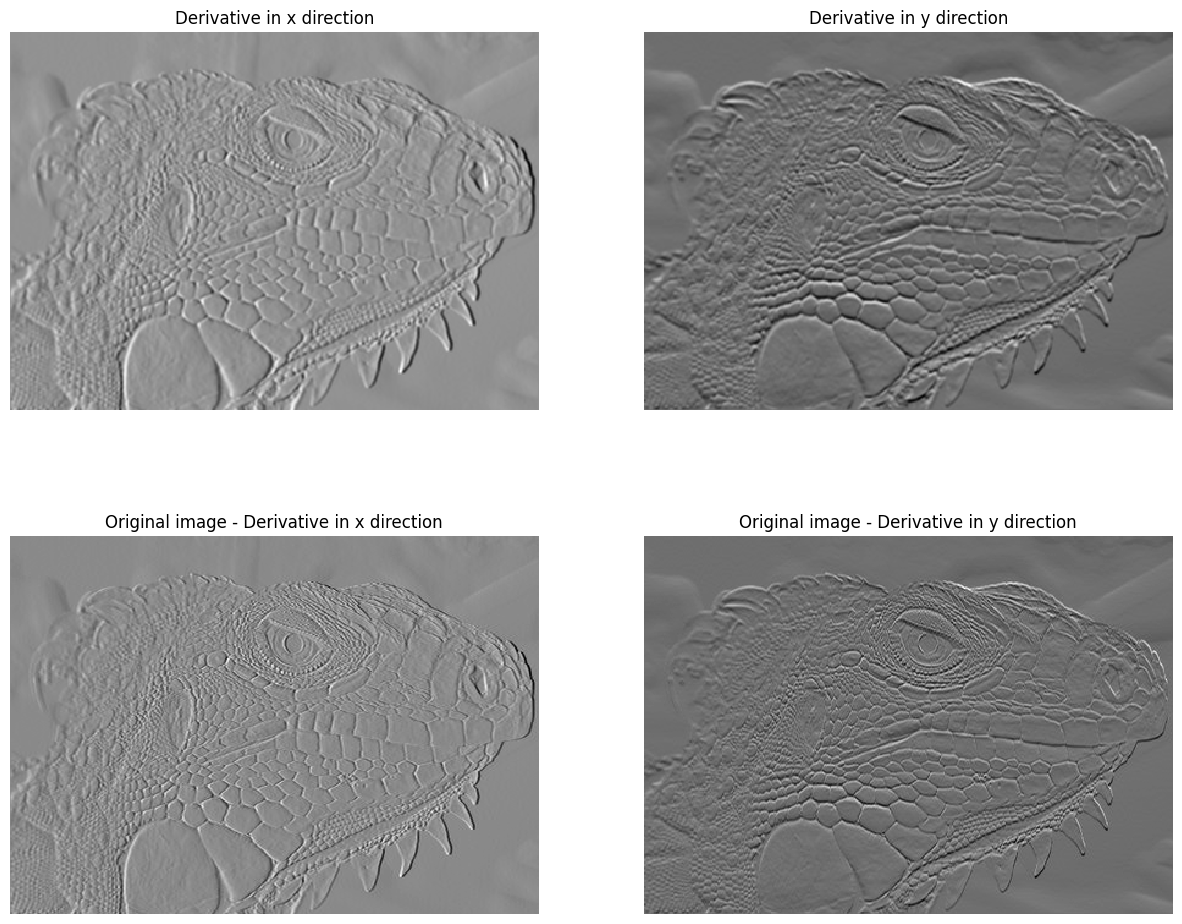

In [42]:
# Compute partial derivatives of smoothed image
Gx = partial_x(smoothed)
Gy = partial_y(smoothed)
img_Gx = partial_x(img)
img_Gy = partial_y(img)

plt.subplot(2,2,1)
plt.imshow(Gx)
plt.title('Derivative in x direction')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(Gy)
plt.title('Derivative in y direction')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(img_Gx)
plt.title('Original image - Derivative in x direction')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(img_Gy)
plt.title('Original image - Derivative in y direction')
plt.axis('off')

plt.show()

#### Implementation
Now, we can compute the magnitude and direction of gradient with the two partial derivatives:

$$
G = \sqrt{G_{x}^{2}+G_{y}^{2}} \\
\Theta = arctan\bigl(\frac{G_{y}}{G_{x}}\bigr)
$$

Implement **`gradient`**  which takes in an image and outputs $G$ and $\Theta$.

*-Hint: Use np.arctan2 to compute $\Theta$.*

In [43]:
def gradient(img):
    """ Returns gradient magnitude and direction of input img.

    Args:
        img: Grayscale image. Numpy array of shape (H, W)

    Returns:
        G: Magnitude of gradient at each pixel in img.
            Numpy array of shape (H, W)
        theta: Direction(in degrees, 0 <= theta < 360) of gradient
            at each pixel in img. Numpy array of shape (H, W)
    """
    G = np.zeros(img.shape)
    theta = np.zeros(img.shape)

    # Sobel Deriviation
    img_x = partial_x(img)
    img_y = partial_y(img)

    x, y = img.shape
    for i in range(x):
        for j in range(y):
            G[i, j] = math.sqrt(img_x[i, j] ** 2 + img_y[i, j] ** 2) # Magnitude
            theta[i, j] = math.atan2(img_y[i, j], img_x[i, j])       # Directions
            if theta[i, j] < 0:   # Make sure the directions are between 0 and 360
                theta[i, j] += 360

    return G, theta

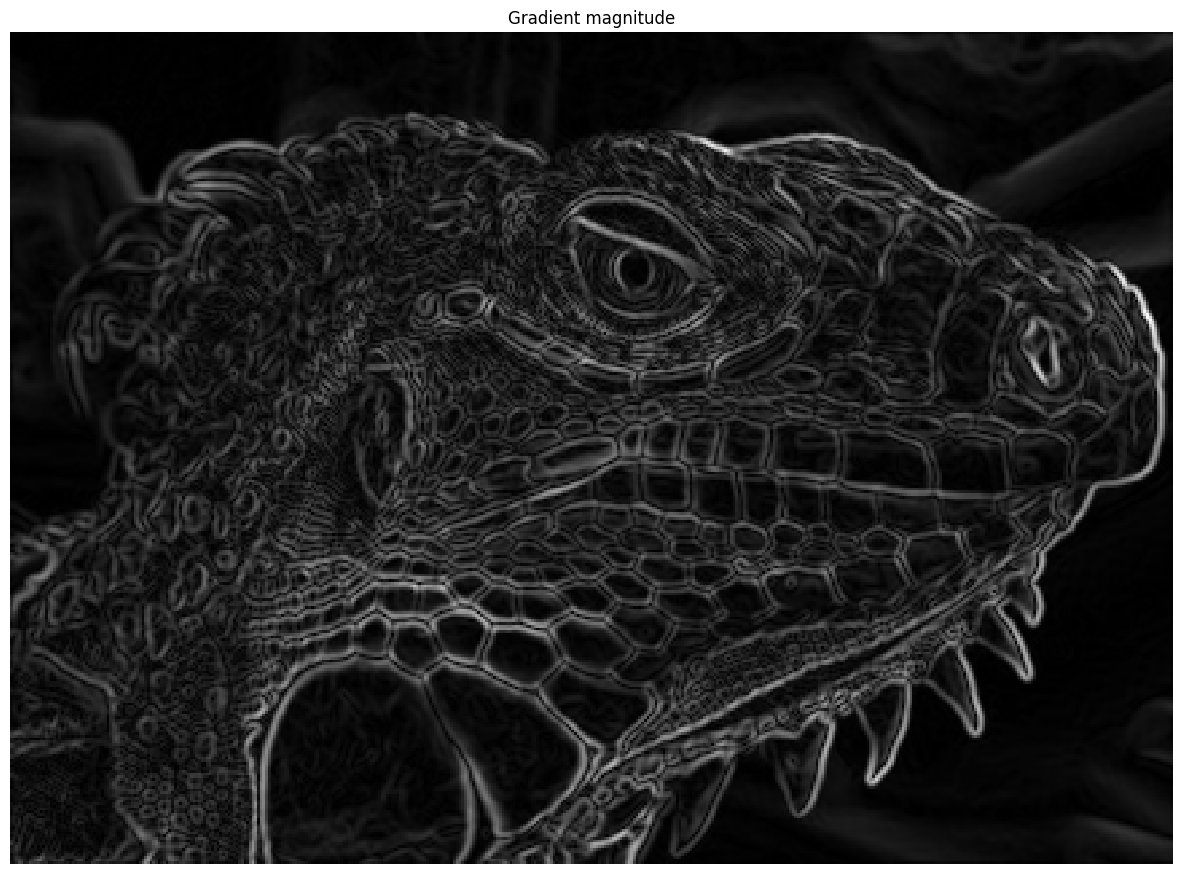

In [47]:
G, theta = gradient(smoothed)

if not np.all(G >= 0):
    print('Magnitude of gradients should be non-negative.')

if not np.all((theta >= 0) * (theta <= 360)):
    print('Direction of gradients should be in range 0 <= theta < 360')

plt.imshow(G)
plt.title('Gradient magnitude')
plt.axis('off')
plt.show()

### 1.3 Non-maximum suppression
You should be able to note that the edges extracted from the gradient of the smoothed image is quite thick and blurry. The purpose of this step is to convert the "blurred" edges into "sharp" edges. Basically, this is done by preserving all local maxima in the gradient image and discarding everything else. The algorithm is for each pixel (x,y) in the gradient image:
1. Round the gradient direction $\Theta[y,x]$ to the nearest 45 degrees, corresponding to the use of an 8-connected neighbourhood.

2. Compare the edge strength of the current pixel with the edge strength of the pixel in the positive and negative gradient direction. For example, if the gradient direction is south (theta=90), compare with the pixels to the north and south.

3. If the edge strength of the current pixel is the largest; preserve the value of the edge strength. If not, suppress (i.e. remove) the value.

Implement **`non_maximum_suppression`**.

In [48]:
def non_maximum_suppression(G, theta):
    """ Performs non-maximum suppression

    This function performs non-maximum suppression along the direction
    of gradient (theta) on the gradient magnitude image (G).

    Args:
        G: gradient magnitude image with shape of (H, W)
        theta: direction of gradients with shape of (H, W)

    Returns:
        out: non-maxima suppressed image
    """
    H, W = G.shape
    out = np.zeros((H+2, W+2))
    pad_width = ((1, 1),(1, 1))
    padded_G = np.pad(G, pad_width, mode='constant')


    # Round the gradient direction to the nearest 45 degrees
    theta = np.floor((theta + 22.5) / 45) * 45

    padded_theta = np.pad(theta, pad_width, mode='constant') # Zero Padding for convenient computing


    for i in range(1, H+1):
        for j in range(1, W+1):
            if padded_theta[i, j] == 0 or padded_theta[i, j] == 360 or padded_theta[i, j] == 180: # Horizontal direction
                if padded_G[i, j] >= padded_G[i, j - 1] and padded_G[i, j] >= padded_G[i, j + 1]: # Apply NMS based on direction
                    out[i, j] = padded_G[i, j]
            
            elif padded_theta[i, j] == 45 or padded_theta[i, j] == 225: # up-left to bottom-right diagonal direction
                if padded_G[i, j] >= padded_G[i - 1, j + 1] and padded_G[i, j] >= padded_G[i + 1, j - 1]: # Apply NMS based on direction
                    out[i, j] = padded_G[i, j]
                
            elif padded_theta[i, j] == 90 or padded_theta[i, j] == 270: # Vertical direction
                if padded_G[i, j] >= padded_G[i - 1, j] and padded_G[i, j] >= padded_G[i + 1, j]: # Apply NMS based on direction
                    out[i, j] = padded_G[i, j]
                
            elif padded_theta[i, j] == 135 or padded_theta[i, j] == 325:  # up-right to bottom-left diagonal direction
                if padded_G[i, j] >= padded_G[i - 1, j - 1] and padded_G[i, j] >= padded_G[i + 1, j + 1]: # Apply NMS based on direction
                    out[i, j] = padded_G[i, j]
                

    return out[1:-1, 1:-1]

In [49]:
# Test input
g = np.array(
    [[0.4, 0.5, 0.6],
     [0.3, 0.5, 0.7],
     [0.4, 0.5, 0.6]]
)

# Print out non-maximum suppressed output
# varying theta
for angle in range(0, 180, 45):
    print('Thetas:', angle)
    t = np.ones((3, 3)) * angle # Initialize theta
    print(non_maximum_suppression(g, t))

Thetas: 0
[[0.  0.  0.6]
 [0.  0.  0.7]
 [0.  0.  0.6]]
Thetas: 45
[[0.4 0.5 0.6]
 [0.  0.  0.7]
 [0.  0.  0.6]]
Thetas: 90
[[0.4 0.5 0. ]
 [0.  0.5 0.7]
 [0.4 0.5 0. ]]
Thetas: 135
[[0.  0.  0.6]
 [0.  0.  0.7]
 [0.4 0.5 0.6]]


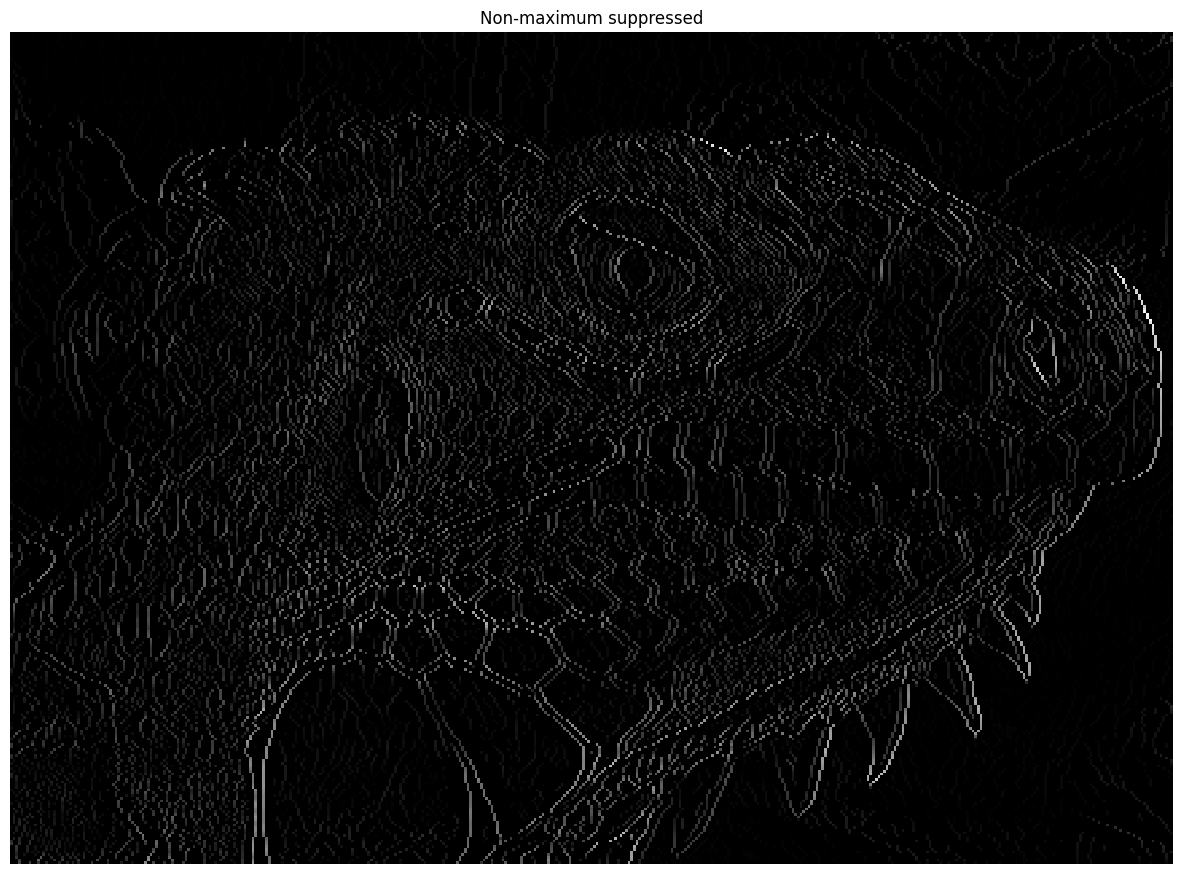

In [50]:
nms = non_maximum_suppression(G, theta)
plt.imshow(nms)
plt.title('Non-maximum suppressed')
plt.axis('off')
plt.show()

### 1.4 Double Thresholding

The edge-pixels remaining after the non-maximum suppression step are (still) marked with their strength pixel-by-pixel. Many of these will probably be true edges in the image, but some may be caused by noise or color variations, for instance, due to rough surfaces. The simplest way to discern between these would be to use a threshold, so that only edges stronger that a certain value would be preserved. The Canny edge detection algorithm uses double thresholding. Edge pixels stronger than the high threshold are marked as strong; edge pixels weaker than the low threshold are suppressed and edge pixels between the two thresholds are marked as weak.

Implement **`double_thresholding`**.

In [51]:
def double_thresholding(img, high, low):
    """
    Args:
        img: numpy array of shape (H, W) representing NMS edge response
        high: high threshold(float) for strong edges
        low: low threshold(float) for weak edges

    Returns:
        strong_edges: Boolean array representing strong edges.
            Strong edeges are the pixels with the values above
            the higher threshold.
        weak_edges: Boolean array representing weak edges.
            Weak edges are the pixels with the values below the
            higher threshould and above the lower threshold.
    """

    strong_edges = np.zeros(img.shape, dtype=bool)
    weak_edges = np.zeros(img.shape, dtype=bool)

    strong_edges[img >= high] = True # Filter elements bigger than upper threshold
    weak_edges[(img >= low) & (img < high)] = True # Filter elements betweem upper threshold and lower threshold

    return strong_edges, weak_edges


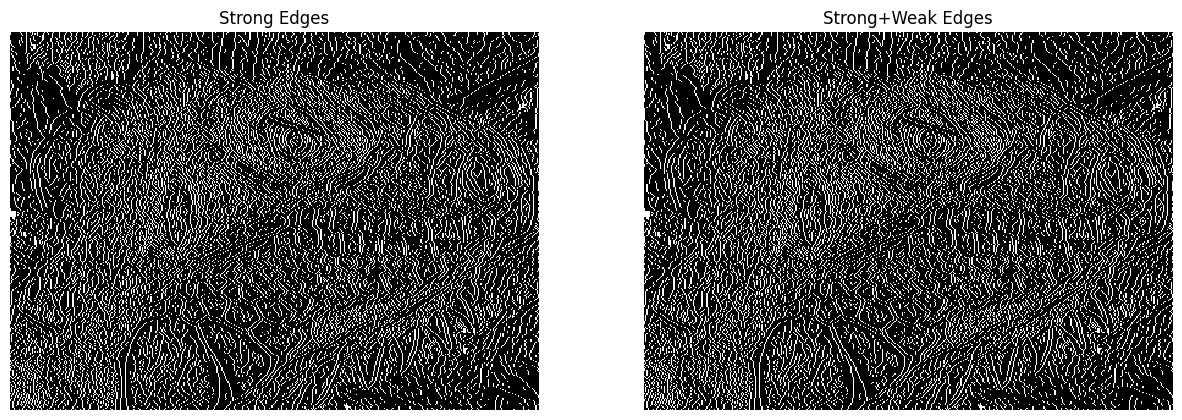

In [52]:
low_threshold = 0.02
high_threshold = 0.03

strong_edges, weak_edges = double_thresholding(nms, high_threshold, low_threshold)
assert(np.sum(strong_edges & weak_edges) == 0)

edges=strong_edges * 1.0 + weak_edges * 0.5

plt.subplot(1,2,1)
plt.imshow(strong_edges)
plt.title('Strong Edges')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(edges)
plt.title('Strong+Weak Edges')
plt.axis('off')

plt.show()

### 1.5 Edge tracking

Strong edges are interpreted as “certain edges”, and can immediately be included in the final edge image. Weak edges are included if and only if they are connected to strong edges. The logic is of course that noise and other small variations are unlikely to result in a strong edge (with proper adjustment of the threshold levels). Thus strong edges will (almost) only be due to true edges in the original image. The weak edges can either be due to true edges or noise/color variations. The latter type will probably be distributed in dependently of edges on the entire image, and thus only a small amount will be located adjacent to strong edges. Weak edges due to true edges are much more likely to be connected directly to strong edges.

Implement **`link_edges`**.

In [54]:
def get_neighbors(y, x, H, W):
    """ Return indices of valid neighbors of (y, x)

    Return indices of all the valid neighbors of (y, x) in an array of
    shape (H, W). An index (i, j) of a valid neighbor should satisfy
    the following:
        1. i >= 0 and i < H
        2. j >= 0 and j < W
        3. (i, j) != (y, x)

    Args:
        y, x: location of the pixel
        H, W: size of the image
    Returns:
        neighbors: list of indices of neighboring pixels [(i, j)]
    """
    neighbors = []

    for i in range(y - 1, y + 2):
        for j in range(x - 1, x + 2):
            if (i >= 0 and i < H) and (j >= 0 and j < W) and (i != y or j != x):
                neighbors.append((i, j))

    return neighbors

In [55]:

def link_edges(strong_edges, weak_edges):
    """ Find weak edges connected to strong edges and link them.

    Iterate over each pixel in strong_edges and perform breadth first
    search across the connected pixels in weak_edges to link them.
    Here we consider a pixel (a, b) is connected to a pixel (c, d)
    if (a, b) is one of the eight neighboring pixels of (c, d).

    Args:
        strong_edges: binary image of shape (H, W)
        weak_edges: binary image of shape (H, W)
    Returns:
        edges: numpy array of shape(H, W)
    """

    H, W = strong_edges.shape
    edges = np.zeros((H, W))
    visited = np.zeros((H, W), dtype=bool)

    # Perform breadth-first search from each strong edge pixel
    for y, x in zip(*np.nonzero(strong_edges)):
        if visited[y, x]:
            continue

        visited[y, x] = True
        edges[y, x] = 1

        queue = deque([(y, x)])

        while queue:
            cur_y, cur_x = queue.popleft()

            # Get neighboring pixels using the get_neighbors function
            neighbors = get_neighbors(cur_y, cur_x, H, W)

            # Check neighboring pixels
            for neighbor_y, neighbor_x in neighbors:
                # Check if the neighbor is a weak edge and unvisited
                if (
                    neighbor_y >= 0
                    and neighbor_y < H
                    and neighbor_x >= 0
                    and neighbor_x < W
                    and weak_edges[neighbor_y, neighbor_x]
                    and not visited[neighbor_y, neighbor_x]
                ):
                    visited[neighbor_y, neighbor_x] = True
                    edges[neighbor_y, neighbor_x] = 1
                    queue.append((neighbor_y, neighbor_x))

    return edges

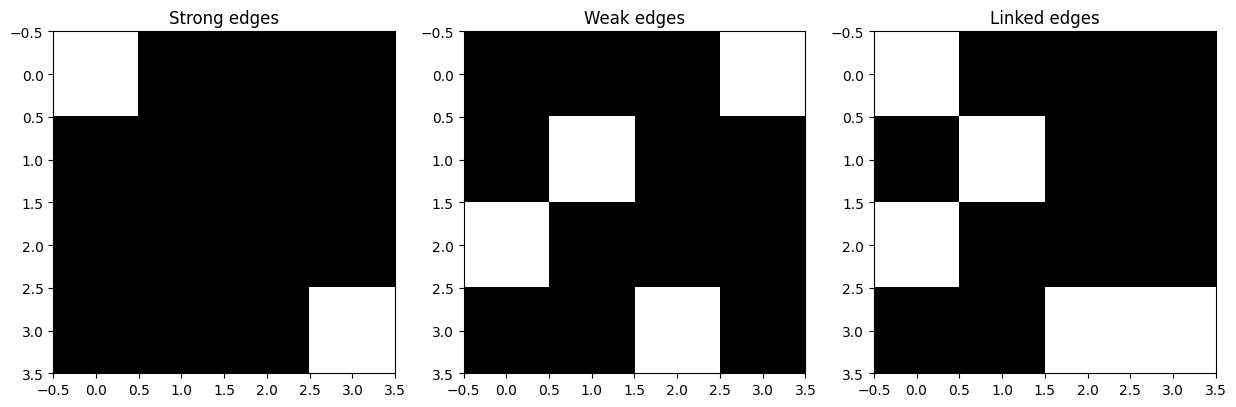

In [56]:
test_strong = np.array(
    [[1, 0, 0, 0],
     [0, 0, 0, 0],
     [0, 0, 0, 0],
     [0, 0, 0, 1]]
)

test_weak = np.array(
    [[0, 0, 0, 1],
     [0, 1, 0, 0],
     [1, 0, 0, 0],
     [0, 0, 1, 0]]
)

test_linked = link_edges(test_strong, test_weak)

plt.subplot(1, 3, 1)
plt.imshow(test_strong)
plt.title('Strong edges')

plt.subplot(1, 3, 2)
plt.imshow(test_weak)
plt.title('Weak edges')

plt.subplot(1, 3, 3)
plt.imshow(test_linked)
plt.title('Linked edges')
plt.show()

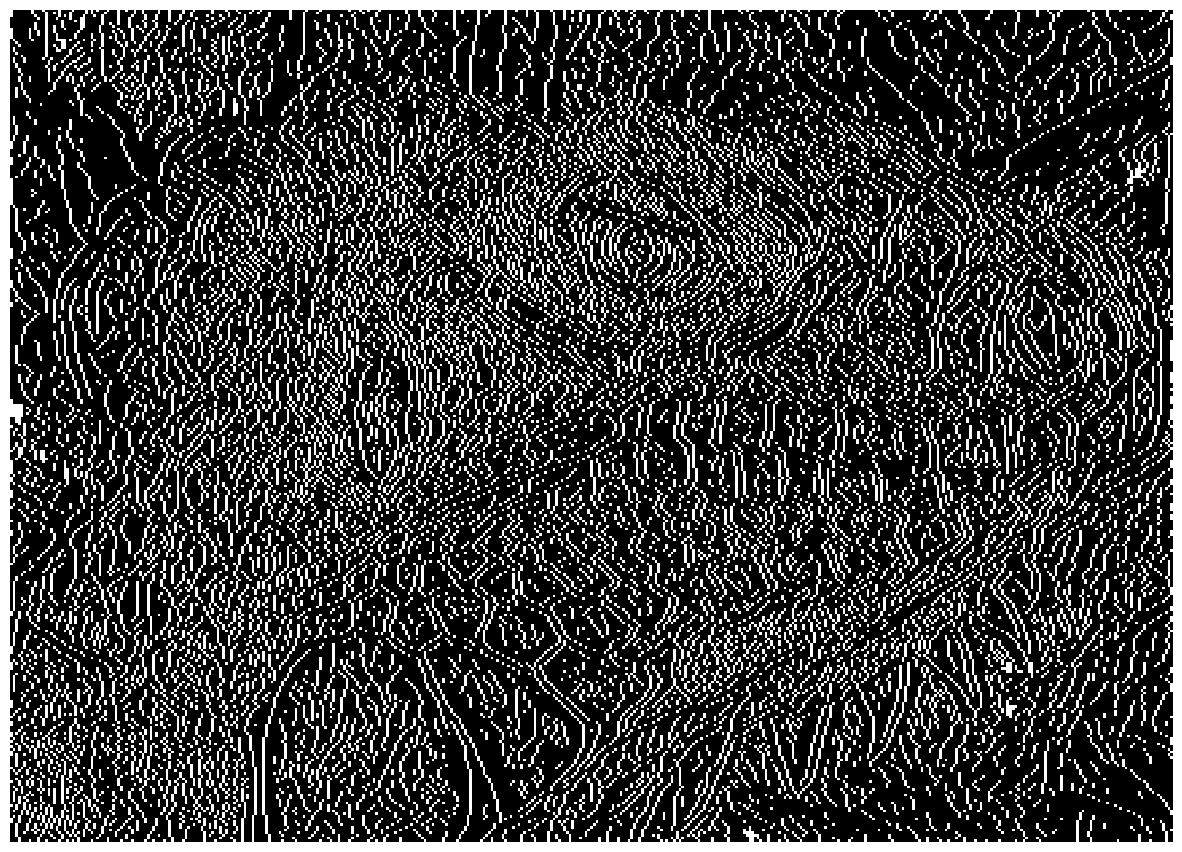

In [57]:
edges = link_edges(strong_edges, weak_edges)

plt.imshow(edges)
plt.axis('off')
plt.show()

### 1.6 Canny edge detector
Implement **`canny`** using the functions you have implemented so far. Test edge detector with different parameters.


In [58]:
def canny(img, kernel_size, sigma, high, low):
    """ Implement canny edge detector by calling functions above.

    Args:
        img: binary image of shape (H, W)
        kernel_size: int of size for kernel matrix
        sigma: float for calculating kernel
        high: high threshold for strong edges
        low: low threashold for weak edges
    Returns:
        edge: numpy array of shape(H, W)
    """
    kernel = gaussian_kernel(kernel_size, sigma)
    
    # Convolve image with kernel to achieve smoothed effect
    smoothed = conv(img, kernel)
    G, T = gradient(smoothed)
    nms_img = non_maximum_suppression(G, T)

    strong_edges, weak_edges = double_thresholding(nms_img, high, low)
    final_edges = link_edges(strong_edges, weak_edges)

    return final_edges

(310, 433)


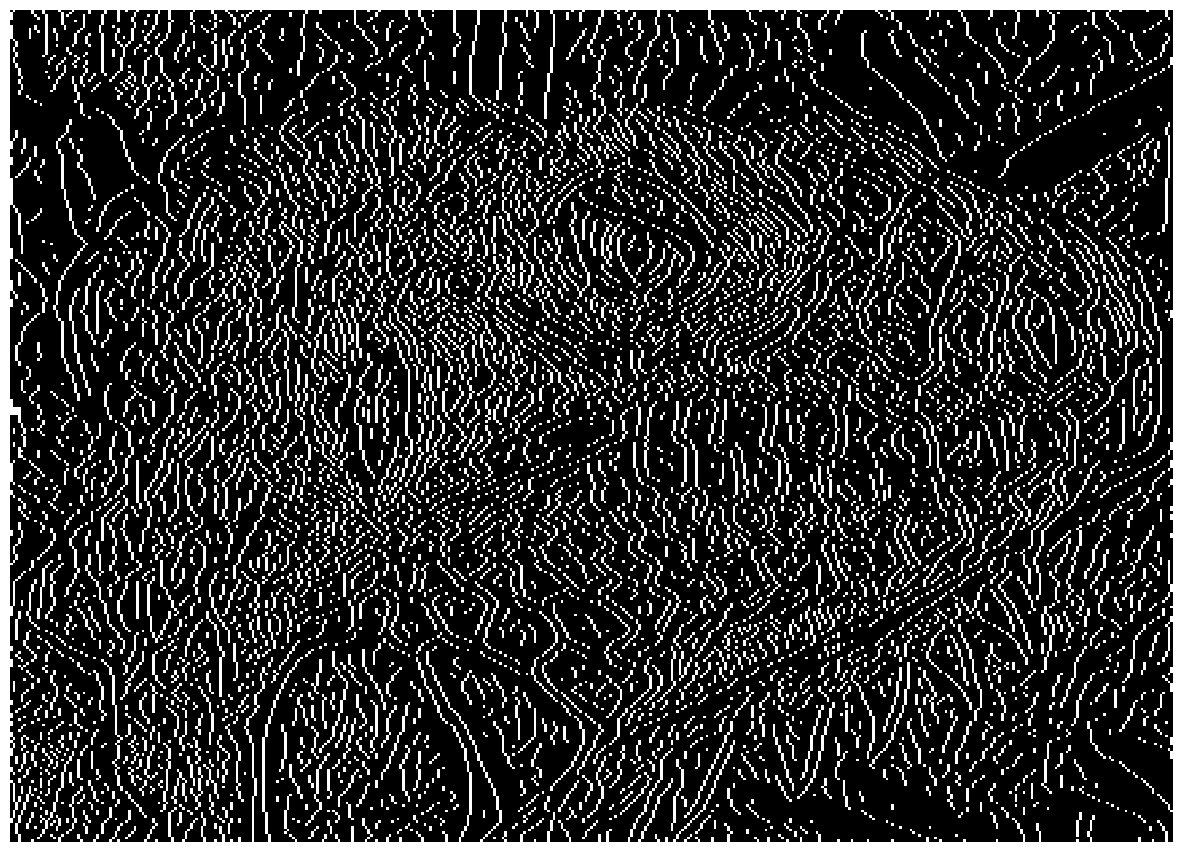

In [59]:
# Load image
# img = io.imread('iguana.png', as_gray=True)
my_img = cv2.imread('iguana.png')
img = cv2.cvtColor(my_img, cv2.COLOR_BGR2GRAY)

# Run Canny edge detector
edges = canny(img, kernel_size=5, sigma=1.4, high=0.03, low=0.02)
print (edges.shape)
plt.imshow(edges)
plt.axis('off')
plt.show()